In [218]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

## Importing part

In [2]:
train = pd.read_csv('train_ctrUa4K.csv')
test = pd.read_csv('test_lAUu6dG.csv')
sample_submission = pd.read_csv('sample_submission_49d68Cx.csv')

target = train['Loan_Status']

idx = len(train)

train.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [3]:
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (614, 13)
Test shape: (367, 12)


In [4]:
# train.info()
# test.info() 

In [5]:
# train.describe(include=np.number)

## Functions...

### Процент выбросов слева / справа от boxplot 

In [148]:
def outliers_percents(col):
    
        length = len(col)
    
        Q1 = np.nanpercentile(col, 25)
        Q3 = np.nanpercentile(col, 75)
        IQR = Q3 - Q1
        
        
        num_outliers_left = len(col[col < Q1 - 1.5 * IQR]) / length
        num_oulliers_right = len(col[col > Q3 + 1.5 * IQR]) / length
        
        return num_outliers_left, num_oulliers_right

### Boxplots subplots (дописать...

In [105]:
# def boxplots_subplots(data, nrows, ncols, remove_empty=False):

#     fig, ax = plt.subplots(nrows, ncols, figsize=(5*nrows, 5*ncols))

#     for i,col in enumerate(list(data.columns.values)):
        
# #         print(col)
        
#         sns.boxplot(data=data[col], orient='h', ax=ax.flatten()[i]);
#         ax.flatten()[i].set_title(col)

#     if remove_empty:
#         fig.delaxes(ax[2,1]) # remove empty subplot
    
#     plt.tight_layout()

In [41]:
# boxplots_subplots(test_num, 3, 2)

### Histplots subplots (дописать...

In [106]:
# def histplots_subplots(data, nrows, ncols, remove_empty=False):
    
#     fig, ax = plt.subplots(nrows, ncols, figsize=(5*nrows, 5*ncols))

#     for i,col in enumerate(list(data.columns.values)):
#         sns.histplot(data[col], ax=ax.flatten()[i], kde=True);

#         num_percent = data[col].isnull().sum() / len(data)
#         ax.flatten()[i].set_title(col+" | missing values: {}%".format(round(num_percent, 2)))

#     if remove_empty:
#         fig.delaxes(ax[2,1]) # remove empty subplot
#     plt.tight_layout()

In [107]:
# histplots_subplots(test_num, 3, 2)

### Combined subplots

In [229]:
def subplots_info(data, remove_empty=False):
    
    fig, ax = plt.subplots(len(data.columns), 2, figsize=(20, 10))

    for i,col in enumerate(list(data.columns.values)):
        
        sns.histplot(data[col], ax=ax[i][0], kde=True);
        sns.boxplot(data=data[col], orient='h', ax=ax[i][1]);

        num_percent = data[col].isnull().sum() / len(data) * 100
        ax[i][0].set_title(col+" | missing values: {}%".format(round(num_percent, 2)))
        
        outliers_left, outliers_right = outliers_percents(data[col])
        ax[i][1].set_title("Left Outliers : {}% ".format(round(outliers_left * 100, 3))+
                           "| Right Outliers : {}%".format(round(outliers_right * 100, 3)))
        

    if remove_empty:
        fig.delaxes(ax[2,1]) # remove empty subplot
    plt.tight_layout()

In [161]:
# subplots_info(train_num)

### IQR outliers handling

In [298]:
def remove_outliers_iqr(data, columns):
    
#     print(columns)
    
    for col in columns:
    
        Q1 = np.nanpercentile(data[col], 25)
        Q3 = np.nanpercentile(data[col], 75)
        IQR = Q3 - Q1
        
        data.loc[data[col] < Q1 - 1.5 * IQR, col] = Q1 - 1.5 * IQR
        data.loc[data[col] > Q3 + 1.5 * IQR, col] = Q3 + 1.5 * IQR
        

### Missing values dealing

In [235]:
def impute(data, columns, how):
    
    if how=='mean':
        for col in columns:
            data[col].fillna(data[col].mean(), inplace=True)
    elif how=='mode':
        for col in columns:
            data[col].fillna(data[col].mode()[0], inplace=True)
    else:
        print('Хз как ?? ')

### Binning (after filling missing values)

In [44]:
# loan_amt = train_num['LoanAmount']

# values = [0, 100, 200, 400, 700]
# labels = ['Low', 'Medium', 'High', 'Very High']

# result = pd.cut(loan_amt, bins=values, labels=labels)
# result.value_counts()

### Freq Encoding

In [45]:
# dict_freq = train_cat['Property_Area'].value_counts(normalize=True)

# train_cat['Property_Area'].map(dict_freq)

### Mapping

In [46]:
# train_cat['Loan_Status'].map({'Y': 1, 'N': 0})
# train_cat

### Dummy variables

In [47]:
# pd.get_dummies(train['Property_Area'])

## Basic feature engineering

###  Spliting num / cat features

In [238]:
train_num = train.select_dtypes(np.number)
test_num = test.select_dtypes(np.number)

train_cat = train.select_dtypes(include='object')
test_cat = test.select_dtypes(include='object')

###  Concating train / test set

In [308]:
num = pd.concat([train_num, test_num], axis=0).reset_index(drop=True)

* NUMERIC 

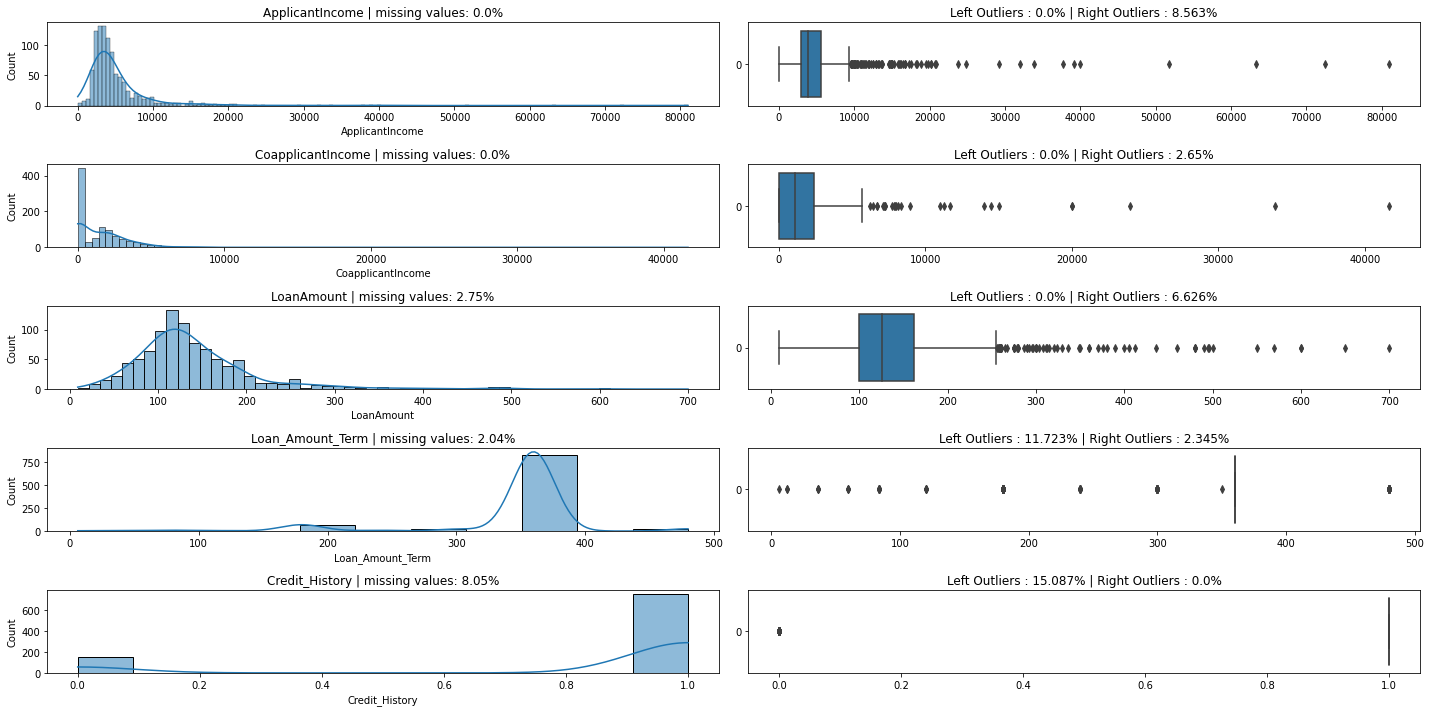

In [240]:
subplots_info(num)

In [241]:
num.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History'],
      dtype='object')

### Removing outliers

In [242]:
remove_outliers_iqr(num, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']);

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']


<ipython-input-175-c88659d40273>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, col][data[col] < Q1 - 1.5 * IQR] = Q1 - 1.5 * IQR
<ipython-input-175-c88659d40273>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, col][data[col] > Q3 + 1.5 * IQR] = Q3 + 1.5 * IQR


### Missing values 

In [243]:
impute(num, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'], 'mean')
impute(num, ['Loan_Amount_Term', 'Credit_History'], 'mode')

num.isnull().sum()

ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
dtype: int64

### Scallling all num data

In [247]:
sc = MinMaxScaler()
num = pd.DataFrame(data=sc.fit_transform(num), 
            columns=num.columns)

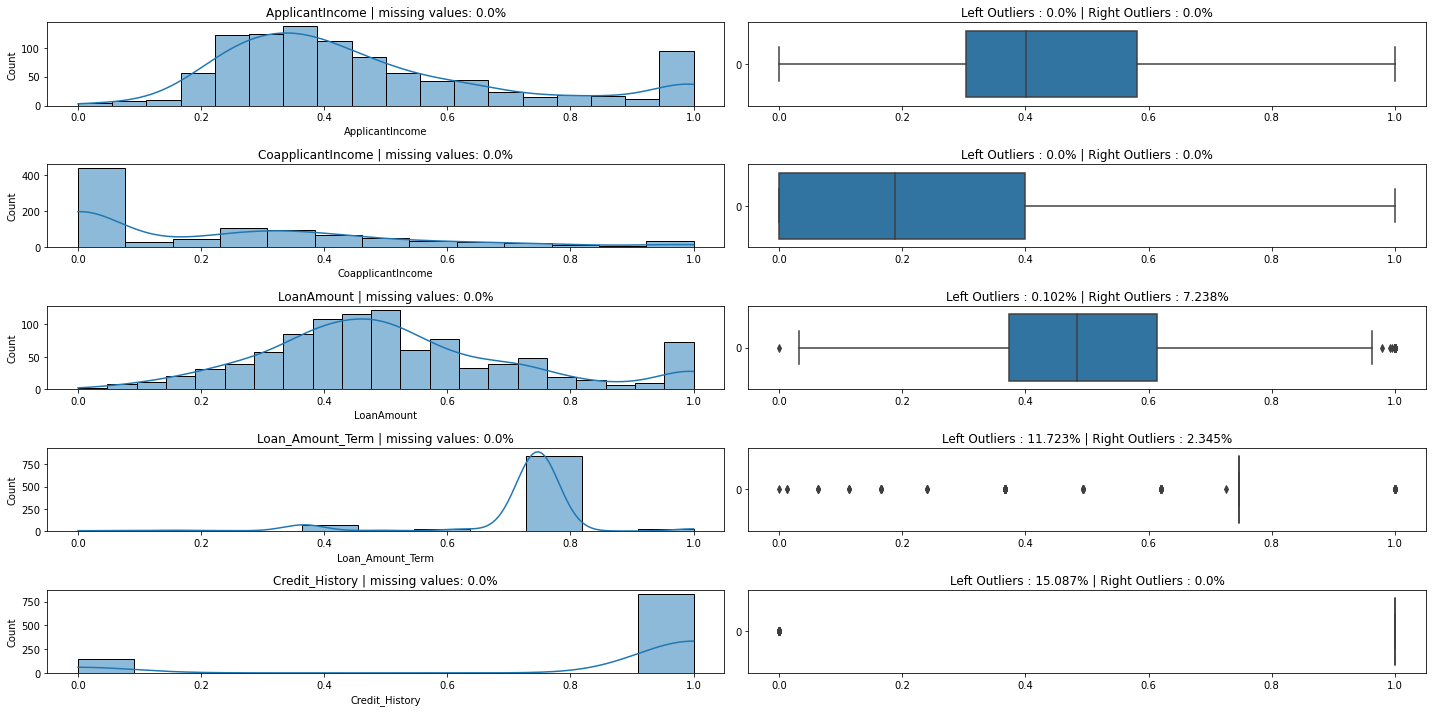

In [248]:
subplots_info(num)

* CATEGORICAL

### Basic exploring

In [322]:
cat = pd.concat([train_cat.iloc[:, :-1], test_cat], axis=0).reset_index(drop=True)

In [323]:
cat.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,LP001002,Male,No,0,Graduate,No,Urban
1,LP001003,Male,Yes,1,Graduate,No,Rural
2,LP001005,Male,Yes,0,Graduate,Yes,Urban
3,LP001006,Male,Yes,0,Not Graduate,No,Urban
4,LP001008,Male,No,0,Graduate,No,Urban


### Dealing with nulls 

In [324]:
cat.isnull().sum() 

Loan_ID           0
Gender           24
Married           3
Dependents       25
Education         0
Self_Employed    55
Property_Area     0
dtype: int64

In [325]:
impute(cat, ['Gender', 'Married', 'Dependents', 'Self_Employed'], 'mode')

### Extracting numbers from Loan_ID

In [326]:
cat['Loan_ID'] = cat['Loan_ID'].map(lambda x: x[4:]).astype('int')

### Mapping features

In [327]:
cat.nunique()

Loan_ID          981
Gender             2
Married            2
Dependents         4
Education          2
Self_Employed      2
Property_Area      3
dtype: int64

In [328]:
cat['Gender'] = cat['Gender'].map({'Male': 0, 'Female': 1})
cat['Married'] = cat['Married'].map({'Yes': 0, 'No': 1})
cat['Education'] = cat['Education'].map({'Graduate': 1, 'Not Graduate': 0})
cat['Self_Employed'] = cat['Self_Employed'].map({'Yes': 0, 'No': 1})

In [329]:
cat.loc[cat['Dependents'] == '3+', 'Dependents'] = 3
cat['Dependents'].value_counts()

0    570
2    160
1    160
3     91
Name: Dependents, dtype: int64

### Get dummies

In [330]:
area_dummies = pd.get_dummies(cat['Property_Area'], drop_first=True).head(3)
area_dummies

,Semiurban,Urban
0,0,1
1,0,0
2,0,1


### Merging it all 

In [331]:
cat.drop(['Property_Area'], axis=1, inplace=True)
cat = pd.concat([cat, area_dummies], axis=1)
cat.head(3)

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Semiurban,Urban
0,1002,0,1,0,1,1,0.0,1.0
1,1003,0,0,1,1,1,0.0,0.0
2,1005,0,0,0,1,0,0.0,1.0


### Scalling 

In [336]:
sc = MinMaxScaler()
cat = pd.DataFrame(data=sc.fit_transform(cat), 
            columns=cat.columns)

C:\Users\vital_pa\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


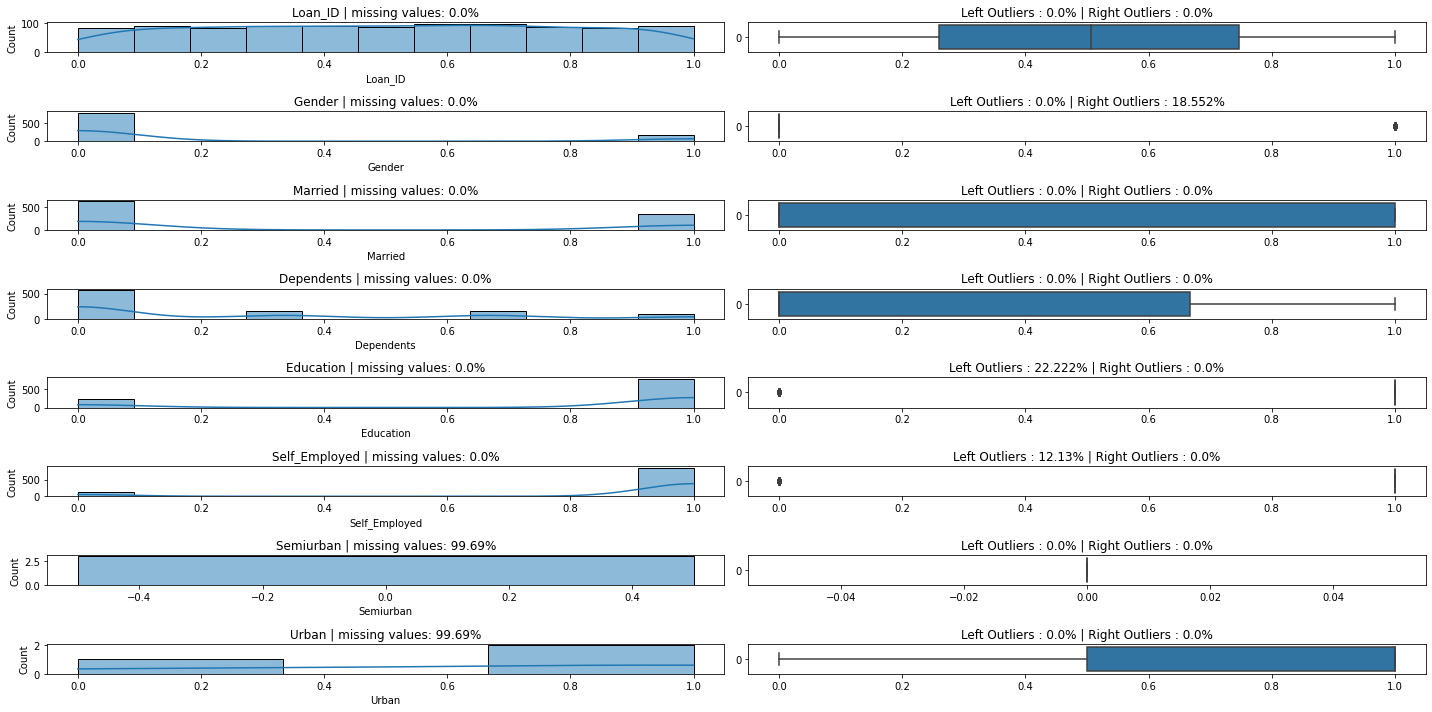

In [335]:
subplots_info(cat)